### Importing Lib's

In [12]:
!nvidia-smi

Fri Apr  4 05:54:53 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 560.35.03              Driver Version: 560.35.03      CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   34C    P8              9W /   70W |       3MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [6]:
import torch
from torch import nn
from pathlib import Path
from torch import nn
import torchvision
from torchvision import transforms,datasets
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import random
from PIL import Image
import matplotlib.pyplot as plt

### Creating Test and Train Data

In [7]:
dir_path = Path("/kaggle/input/fer2013")
dir_path
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

random_images = list(dir_path.glob("*/*/*.jpg"))

### Opening any random image

In [3]:
img = random.choice(random_images)
t = img.parent.stem
img = Image.open(img)
plt.imshow(img, cmap="gray")
plt.title(t)
plt.axis("off")

IndexError: Cannot choose from an empty sequence

### Creating tranformer 

In [29]:
data_transform = transforms.Compose([
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

### Checking the transform on a single image


(-0.5, 47.5, 47.5, -0.5)

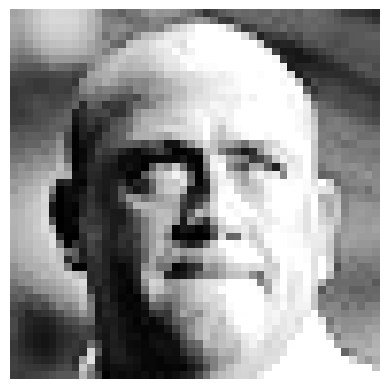

In [30]:
tran_img = data_transform(img)

plt.imshow(tran_img.permute(1,2,0),cmap="gray")
plt.axis("off")

### Creating datasets and dataloader

In [31]:
train_dataset = datasets.ImageFolder(root=train_dir,transform=data_transform)
test_dataset = datasets.ImageFolder(root=test_dir,transform=data_transform)

train_dataloader = DataLoader(dataset=train_dataset,batch_size=32,shuffle=True,num_workers=4)
test_dataloader = DataLoader(dataset=test_dataset,batch_size=32,shuffle=False,num_workers=4)

# train_dataloader,test_dataloader
# len(train_dataset),len(test_dataset)
train_dataset[0][0].shape,train_dataset.classes[train_dataset[0][1]]
classes = train_dataset.classes

### Creating model architect (TinyVGG)


In [32]:
class TinyVGG(nn.Module):
    def __init__(self,input_shape,hidden_units,output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*9*9,out_features=output_shape)
        )
    def forward(self,x):
        return self.classifier(self.conv_block_2(self.conv_block_1(x)))


model = TinyVGG(input_shape=3,hidden_units=10,output_shape=len(classes))

### creating training and testing loop

In [33]:
from tqdm.auto import tqdm
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model.parameters(),lr=1e-5)
device = "cuda" if torch.cuda.is_available() else "cpu"

def train_step(model, dataloader, loss_fn, optimizer, device):
    model.train()
    train_loss = 0
    train_acc = 0
    
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        
        # Forward pass
        outputs = model(X)
        logits = outputs.logits 
        
        # Compute loss
        loss = loss_fn(logits, y)
        
        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Track loss and accuracy
        train_loss += loss.item()
        acc = (logits.argmax(dim=1) == y).float().mean().item()
        train_acc += acc

    return train_loss / len(dataloader), train_acc / len(dataloader)


def test_step(model, dataloader, loss_fn, device):
    model.eval()
    test_loss = 0
    test_acc = 0
    with torch.inference_mode():
        for batch,(X,y) in enumerate(dataloader):
            X,y = X.to(device),y.to(device)
            y_pred = model(X)
            loss = loss_fn(y_pred,y)
            test_loss += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item()/len(y_pred)
            test_acc += acc
    return test_loss/len(dataloader),test_acc/len(dataloader)

def train(model,train_dataloader,test_dataloader,loss_fn,optimizer,epochs,device):
    result = {
        "train_loss":[],
        "train_acc":[],
        "test_loss":[],
        "test_acc":[]
    }
    for epoch in tqdm(range(epochs)):
        print(f"Epoch {epoch+1}/{epochs}")
        train_loss,train_acc = train_step(model=model,
                                          dataloader=train_dataloader,
                                          loss_fn=loss_fn,
                                          optimizer=optimizer,
                                          device=device)
        test_loss,test_acc = test_step(model=model,
                                       dataloader=test_dataloader,
                                       loss_fn=loss_fn,
                                       device=device)
        result["train_loss"].append(train_loss)
        result["train_acc"].append(train_acc)
        result["test_loss"].append(test_loss)
        result["test_acc"].append(test_acc)
        print(f"Train loss: {train_loss:.5f} | Train acc: {train_acc:.2f} | Test loss: {test_loss:.5f} | Test acc: {test_acc:.2f}")
    return result

# result = train(model=model,train_dataloader=train_dataloader,test_dataloader=test_dataloader,loss_fn=loss_fn,optimizer=optimizer,epochs=5,device=device)


# result

## Plotting Loss Curve

In [34]:
def plot_loss_curves(results):
    """
    Plots training curves of a results dictionary.
    
    Args:
        results (dict): Dictionary containing lists of values, specifically:
            - train_loss
            - train_acc
            - test_loss
            - test_acc
    """
    loss = results['train_loss']
    test_loss = results['test_loss']

    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    epochs = range(len(results['train_loss']))

    plt.figure(figsize=(15, 7))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='Train Loss')
    plt.plot(epochs, test_loss, label='Test Loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='Train Accuracy')
    plt.plot(epochs, test_accuracy, label='Test Accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()

# plot_loss_curves(result)

### Fine Tunning the Google ViT-B-16 Model

In [38]:
import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm.auto import tqdm

# Paths
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading Model.........\n")
model_1 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(classes))

# Enable multi-GPU training if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model_1 = torch.nn.DataParallel(model_1)  # Wrap model in DataParallel

model_1.to(device)  # Move model to GPU(s)

# Loss

loss_fn = nn.CrossEntropyLoss()
# Optimizer
optimizer_1 = torch.optim.Adam(params=model_1.parameters(), lr=1e-5)

# Freezing all parameters except classifier
for param in model_1.parameters():
    param.requires_grad = False
for param in model_1.module.classifier.parameters():  # Use `.module` for DataParallel
    param.requires_grad = True

# Data Transformation
data_transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

# Datasets
train_dataset_1 = datasets.ImageFolder(root=train_dir, transform=data_transform_1)
test_dataset_1 = datasets.ImageFolder(root=test_dir, transform=data_transform_1)

# DataLoaders (reduce workers if training slows)
train_dataloader_1 = DataLoader(train_dataset_1, batch_size=7, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=7, shuffle=False, num_workers=4, pin_memory=True)

# Training Variables
train_loss = []
train_acc = []
test_loss = []
test_acc = []
EPOCHS = 20

# Training Loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_1.train()

    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch = 0
    test_acc_epoch = 0

    # Training Step
    for X, y in train_dataloader_1:
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_1(X).logits
        loss = loss_fn(outputs, y)
        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc
        train_loss.append(loss.item())
        train_acc.append(acc)

    train_loss_epoch /= len(train_dataloader_1)
    train_acc_epoch /= len(train_dataloader_1)
    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f}")

    # Evaluation
    model_1.eval()
    with torch.inference_mode():
        for X, y in test_dataloader_1:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_1(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc
            test_loss.append(loss.item())
            test_acc.append(acc)

    test_loss_epoch /= len(test_dataloader_1)
    test_acc_epoch /= len(test_dataloader_1)
    print(f"Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")

Loading Model.........



config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Using 2 GPUs...


  0%|          | 0/20 [00:00<?, ?it/s]

1/20.........
Train loss: 1.83510 | Train acc: 0.26


NameError: name 'test_loss_epoc' is not defined

### Plotting Lost Curve

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

def plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch):
    # Aggregate per epoch
    num_epochs = len(train_loss) // batches_per_epoch
    
    train_loss_epoch = [np.mean(train_loss[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    test_loss_epoch = [np.mean(test_loss[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    train_acc_epoch = [np.mean(train_acc[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    test_acc_epoch = [np.mean(test_acc[i * batches_per_epoch:(i + 1) * batches_per_epoch]) for i in range(num_epochs)]
    
    epochs = range(num_epochs)

    plt.figure(figsize=(12, 5))

    # Loss Curves
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_loss_epoch, label='Train Loss', marker='o')
    plt.plot(epochs, test_loss_epoch, label='Test Loss', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Curves')

    # Accuracy Curves
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_acc_epoch, label='Train Accuracy', marker='o')
    plt.plot(epochs, test_acc_epoch, label='Test Accuracy', marker='o')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Curves')

    plt.show()
batches_per_epoch = len(train_dataloader_1)

plot_loss_curves(train_loss, train_acc, test_loss, test_acc, batches_per_epoch)


### Saving the current model

In [ ]:
torch.save(model_1.state_dict(),"/kaggle/working/model_1.pth")
# len(train_dataloader_1)

### Changing the BATCH SIZE 

In [ ]:
import torch
import torch.nn as nn
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
from transformers import ViTForImageClassification
from tqdm.auto import tqdm

# Paths
train_dir = "/kaggle/input/fer2013/train"
test_dir = "/kaggle/input/fer2013/test"

# Device Configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

print("Loading Model.........\n")
model_2 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(classes))

# Enable multi-GPU training if multiple GPUs are available
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model_2 = torch.nn.DataParallel(model_2)  # Wrap model in DataParallel

model_2.to(device)  # Move model to GPU(s)

# Loss Function
loss_fn = nn.CrossEntropyLoss()

# Optimizer
optimizer_1 = torch.optim.Adam(params=model_2.parameters(), lr=1e-5)

# Freezing all parameters except classifier
for param in model_2.parameters():
    param.requires_grad = False

# Handle DataParallel `.module` issue
classifier_params = model_2.module.classifier.parameters() if isinstance(model_2, torch.nn.DataParallel) else model_2.classifier.parameters()
for param in classifier_params:
    param.requires_grad = True

# Data Transformation
data_transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

# Datasets
train_dataset_1 = datasets.ImageFolder(root=train_dir, transform=data_transform_1)
test_dataset_1 = datasets.ImageFolder(root=test_dir, transform=data_transform_1)

# DataLoaders (reduce workers if training slows)
train_dataloader_1 = DataLoader(train_dataset_1, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader_1 = DataLoader(test_dataset_1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

# Training Variables
train_loss_model2 = []
train_acc_model2 = []
test_loss_model2 = []
test_acc_model2 = []
EPOCHS = 20

# Training Loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_2.train()

    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch = 0
    test_acc_epoch = 0

    # Training Step
    for batch_idx, (X, y) in enumerate(train_dataloader_1):  
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_2(X).logits
        loss = loss_fn(outputs, y)

        optimizer_1.zero_grad()
        loss.backward()
        optimizer_1.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc
        train_loss.append(loss.item())
        train_acc.append(acc)

        # Print batch info every 8 batches
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(train_dataloader_1)
    train_acc_epoch /= len(train_dataloader_1)

    # Evaluation
    model_2.eval()
    with torch.inference_mode():
        for X, y in test_dataloader_1:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_2(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc
            test_loss.append(loss.item())
            test_acc.append(acc)

    test_loss_epoch /= len(test_dataloader_1)
    test_acc_epoch /= len(test_dataloader_1)
    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")


### Saving the Model

In [ ]:
torch.save(model_2.state_dict(),"/kaggle/working/model/model_2.pth")
print("Model 2 saved successfully!")

In [ ]:
batches_per_epoch = len(train_dataloader_1)
plot_loss_curves(train_loss_model2, train_acc_model2, test_loss_model2, test_acc_model2, batches_per_epoch)

### Now  I'll do fine-tuning by unfreezing 3 more layers for model to adapt the facial emotions

In [8]:
from transformers import ViTForImageClassification

model_3 = ViTForImageClassification.from_pretrained("google/vit-base-patch16-224-in21k", num_labels=len(classes))

#checking for multiple GPUS

if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs...")
    model_3 = torch.nn.DataParallel(model_3)  # Wrap model in DataParallel
model_3.to(device)


model.load_state_dict(torch.load("/kaggle/output/model/model_2.pth"))

#Unfreezing the last 3 layers
for param in model.module.vit.encoder.layer[-3:].parameters():
    param.requires_grad = True
print("Unfroze last 3 ViT layers!")


loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_3.parameters(), lr=1e-5)

#Transformations
data_transform_1 = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.TrivialAugmentWide(31),
    transforms.ToTensor(),
])

# Datasets
train_dataset_1 = datasets.ImageFolder(root=train_dir, transform=data_transform_1)
test_dataset_1 = datasets.ImageFolder(root=test_dir, transform=data_transform_1)

#Dataloader
train_dataloader_3 = DataLoader(train_dataset_1, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
test_dataloader_3 = DataLoader(test_dataset_1, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)

#Training Variables
train_loss_model3 = []
train_acc_model3 = []
test_loss_model3 = []
test_acc_model3 = []
EPOCHS = 20

#Training Loop
for epoch in tqdm(range(EPOCHS)):
    print(f"{epoch + 1}/{EPOCHS}.........")
    model_3.train()

    train_loss_epoch = 0
    train_acc_epoch = 0
    test_loss_epoch = 0
    test_acc_epoch = 0

    # Training Step
    for batch_idx, (X, y) in enumerate(train_dataloader_3):  
        X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
        outputs = model_3(X).logits
        loss = loss_fn(outputs, y)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        train_loss_epoch += loss.item()
        acc = (outputs.argmax(1) == y).sum().item() / len(y)
        train_acc_epoch += acc
        train_loss.append(loss.item())
        train_acc.append(acc)

        # Print batch info every 8 batches
        if batch_idx % 200 == 0:
            print(f"Batch {batch_idx} | Train loss: {loss.item():.5f} | Train acc: {acc:.2f}")

    train_loss_epoch /= len(test_dataloader_3)
    train_acc_epoch /= len(train_dataloader_3)

    # Evaluation
    model_3.eval()
    with torch.inference_mode():
        for X, y in test_dataloader_3:
            X, y = X.to(device, non_blocking=True), y.to(device, non_blocking=True)
            y_pred = model_3(X).logits
            loss = loss_fn(y_pred, y)

            test_loss_epoch += loss.item()
            acc = (y_pred.argmax(1) == y).sum().item() / len(y)
            test_acc_epoch += acc
            test_loss.append(loss.item())
            test_acc.append(acc)

    test_loss_epoch /= len(test_dataloader_3)
    test_acc_epoch /= len(test_dataloader_3)
    print(f"Train loss: {train_loss_epoch:.5f} | Train acc: {train_acc_epoch:.2f} | Test loss: {test_loss_epoch:.5f} | Test acc: {test_acc_epoch:.2f}")




KeyboardInterrupt: 

### Plotting Loss Curve

In [ ]:
batches_per_epoch = len(train_dataloader_3)
plot_loss_curves(train_loss_model3, train_acc_model3, test_loss_model3, test_acc_model3, batches_per_epoch)